<a href="https://colab.research.google.com/github/mk2436/CYBERSECURITY-PREDICTION-MODEL/blob/main/models/Humans_Of_AI(28)_projectAssignment3_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score
import xgboost as xgb
import matplotlib.pyplot as plt
from google.colab import files

uploaded = files.upload()

file_name = list(uploaded.keys())[0]
original_data = pd.read_csv(file_name)
rf_data = pd.read_csv(file_name)

# Display the first few rows to understand the dataset
print("Dataset Preview:")
print(original_data.head())


Saving cybersecurity_attacks.csv to cybersecurity_attacks.csv
Dataset Preview:
             Timestamp Source IP Address Destination IP Address  Source Port  \
0  2023-05-30 06:33:58     103.216.15.12           84.9.164.252        31225   
1  2020-08-26 07:08:30    78.199.217.198         66.191.137.154        17245   
2  2022-11-13 08:23:25      63.79.210.48          198.219.82.17        16811   
3  2023-07-02 10:38:46     163.42.196.10        101.228.192.255        20018   
4  2023-07-16 13:11:07     71.166.185.76        189.243.174.238         6131   

   Destination Port Protocol  Packet Length Packet Type Traffic Type  \
0             17616     ICMP            503        Data         HTTP   
1             48166     ICMP           1174        Data         HTTP   
2             53600      UDP            306     Control         HTTP   
3             32534      UDP            385        Data         HTTP   
4             26646      TCP           1462        Data          DNS   

       

In [ ]:
# Overview of the Dataset
original_data.describe()

Source Port  Destination Port  Packet Length  Anomaly Scores
count  40000.000000      40000.000000   40000.000000    40000.000000
mean   32970.356450      33150.868650     781.452725       50.113473
std    18560.425604      18574.668842     416.044192       28.853598
min     1027.000000       1024.000000      64.000000        0.000000
25%    16850.750000      17094.750000     420.000000       25.150000
50%    32856.000000      33004.500000     782.000000       50.345000
75%    48928.250000      49287.000000    1143.000000       75.030000
max    65530.000000      65535.000000    1500.000000      100.000000

Data Preprocessing

In [ ]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               40000 non-null  object 
 1   Source IP Address       40000 non-null  object 
 2   Destination IP Address  40000 non-null  object 
 3   Source Port             40000 non-null  int64  
 4   Destination Port        40000 non-null  int64  
 5   Protocol                40000 non-null  object 
 6   Packet Length           40000 non-null  int64  
 7   Packet Type             40000 non-null  object 
 8   Traffic Type            40000 non-null  object 
 9   Payload Data            40000 non-null  object 
 10  Malware Indicators      20000 non-null  object 
 11  Anomaly Scores          40000 non-null  float64
 12  Alerts/Warnings         19933 non-null  object 
 13  Attack Type             40000 non-null  object 
 14  Attack Signature        40000 non-null

**Approach 1: Using XGBoost Classifier**

In [ ]:
data = original_data.drop(columns=['Alerts/Warnings', 'IDS/IPS Alerts', 'Malware Indicators','Firewall Logs', 'Proxy Information', 'Timestamp'])  # Replace 'geo location' with the exact column name

# Display updated dataset structure to verify
print("Columns after dropping 'geo location':")
print(data.columns)

Columns after dropping 'geo location':
Index(['Source IP Address', 'Destination IP Address', 'Source Port',
       'Destination Port', 'Protocol', 'Packet Length', 'Packet Type',
       'Traffic Type', 'Payload Data', 'Anomaly Scores', 'Attack Type',
       'Attack Signature', 'Action Taken', 'Severity Level',
       'User Information', 'Device Information', 'Network Segment',
       'Geo-location Data', 'Log Source'],
      dtype='object')


In [ ]:
data.shape

(40000, 19)

In [ ]:
# Fill missing values for categorical columns with 'Unknown'
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].fillna('Unknown')

# Fill missing values for numerical columns with the median
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())


Encode Categorical Variables

In [ ]:
# Label Encoding for categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


Feature and Target Selection

In [ ]:
# Separate features (X) and target variable (y)
X = data.drop(columns=['Attack Type'])
y = data['Attack Type']

# Encode the target variable if it is categorical
y = LabelEncoder().fit_transform(y)


Split the Dataset

In [ ]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape}")
print(f"Test Set Size: {X_test.shape}")


Training Set Size: (32000, 18)
Test Set Size: (8000, 18)


Build and Train the XGBoost Model

In [ ]:
from sklearn.model_selection import GridSearchCV

class_weights = dict({i: 1 for i in range(len(np.unique(y)))})  # Default equal weights

# Initialize the XGBoost classifier with basic parameters
model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    eval_metric='mlogloss',      # Evaluation metric
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=class_weights
)

In [ ]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Step 1: Balance the Dataset (if necessary)
print("Class Distribution Before Balancing:")
print(pd.Series(y).value_counts())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class Distribution After Balancing:")
print(pd.Series(y_resampled).value_counts())

# Step 2: Feature Selection using Feature Importance
model_temp = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model_temp.fit(X_resampled, y_resampled)

# Extract important features
feature_importances = model_temp.feature_importances_
important_features = [X.columns[i] for i in range(len(feature_importances)) if feature_importances[i] > 0.01]

# Filter the dataset
X_filtered = X_resampled[important_features]

# Step 3: Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
}


grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_filtered, y_resampled)

# Best Parameters
best_params = grid_search.best_params_
print("Best Parameters Found:", best_params)

# Step 4: Train with Tuned Parameters
final_model = xgb.XGBClassifier(
    **best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42
)
final_model.fit(X_filtered, y_resampled)

# Evaluate on Test Set
X_test_filtered = X_test[important_features]
y_pred = final_model.predict(X_test_filtered)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Improved Accuracy: {accuracy:.2f}")
print(f"Improved F1 Score: {f1:.2f}")
print(f"Improved Recall: {recall:.2f}")


Class Distribution Before Balancing:
0    13428
2    13307
1    13265
Name: count, dtype: int64
Class Distribution After Balancing:
2    13428
0    13428
1    13428
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:56:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:06:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters Found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:06:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Improved Accuracy: 0.92
Improved F1 Score: 0.92
Improved Recall: 0.92


Final Classification Report for XGBoost

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


# Generate metrics report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      2686
           1       0.91      0.92      0.92      2653
           2       0.92      0.92      0.92      2661

    accuracy                           0.92      8000
   macro avg       0.92      0.92      0.92      8000
weighted avg       0.92      0.92      0.92      8000

Confusion Matrix:
 [[2455  127  104]
 [  91 2451  111]
 [  94  112 2455]]


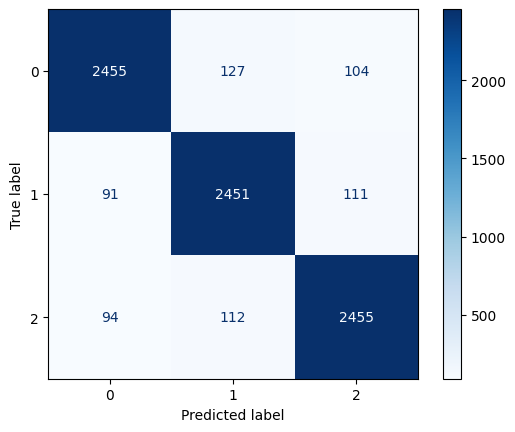

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)

# Display the confusion matrix
disp.plot(cmap="Blues", values_format="d")

**Approach 2: Using Random Forest Classifier**

Dropping the "Geo - Location Data" feature to eliminate bias

In [3]:
# Drop the "Geo-location Data" column
rf_data.drop(columns=["Geo-location Data"], inplace=True)

print("Columns after dropping 'Geo-location Data':")
print(rf_data.columns)

Columns after dropping 'Geo-location Data':
Index(['Timestamp', 'Source IP Address', 'Destination IP Address',
       'Source Port', 'Destination Port', 'Protocol', 'Packet Length',
       'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators',
       'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature',
       'Action Taken', 'Severity Level', 'User Information',
       'Device Information', 'Network Segment', 'Proxy Information',
       'Firewall Logs', 'IDS/IPS Alerts', 'Log Source'],
      dtype='object')


Hanlding Missing Vlaues

In [4]:
# Fill missing values for categorical columns with 'Unknown'
rf_categorical_cols = rf_data.select_dtypes(include=['object']).columns
rf_data[rf_categorical_cols] = rf_data[rf_categorical_cols].fillna('Unknown')

# Fill missing values for numerical columns with the median
rf_numerical_cols = rf_data.select_dtypes(include=['int64', 'float64']).columns
rf_data[rf_numerical_cols] = rf_data[rf_numerical_cols].fillna(rf_data[rf_numerical_cols].median())


Encode Categorical Variables

In [5]:
# Label Encoding for categorical features
rf_label_encoders = {}
for col in rf_categorical_cols:
    rf_le = LabelEncoder()
    rf_data[col] = rf_le.fit_transform(rf_data[col])
    rf_label_encoders[col] = rf_le


Feature and Target Selection

In [6]:
# Separate features (X) and target variable (y)
rf_target_column = "Attack Type"  # Replace with the actual target column name
rf_X = rf_data.drop(columns=[rf_target_column])
rf_y = rf_data[rf_target_column]

# Encode the target variable
rf_y = LabelEncoder().fit_transform(rf_y)

# Shapes of X and y
print(rf_X.shape, rf_y.shape)

(40000, 23) (40000,)


Splitting the Dataset

In [7]:
# Split into training and testing datasets
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(
    rf_X, rf_y, test_size=0.2, random_state=42, stratify=rf_y
)

print(f"Training Set Size: {rf_X_train.shape}")
print(f"Test Set Size: {rf_X_test.shape}")


Training Set Size: (32000, 23)
Test Set Size: (8000, 23)


Train and Test Random Forest Model

In [8]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
from imblearn.over_sampling import SMOTE

# Step 1: Balance the Dataset (if necessary)
print("Class Distribution Before Balancing:")
print(pd.Series(rf_y).value_counts())

smote = SMOTE(random_state=42)
rf_X_resampled, rf_y_resampled = smote.fit_resample(rf_X, rf_y)

print("Class Distribution After Balancing:")
print(pd.Series(rf_y_resampled).value_counts())

# Step 2: Feature Selection using Feature Importance
rf_model_temp = RandomForestClassifier(random_state=42)
rf_model_temp.fit(rf_X_resampled, rf_y_resampled)

# Extract important features
rf_feature_importances = rf_model_temp.feature_importances_
rf_important_features = [rf_X.columns[i] for i in range(len(rf_feature_importances)) if rf_feature_importances[i] > 0.01]

# Printing important features
print(rf_important_features)

# Filter the dataset
rf_X_filtered = rf_X_resampled[rf_important_features]

# Step 3: Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4, 8],
}


rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

rf_grid_search.fit(rf_X_filtered, rf_y_resampled)

# Best Parameters
rf_best_params = rf_grid_search.best_params_
print("Best Parameters Found:", rf_best_params)

# Step 4: Train with Tuned Parameters
rf_final_model = RandomForestClassifier(**rf_best_params, random_state=42)
rf_final_model.fit(rf_X_filtered, rf_y_resampled)

# Evaluate on Test Set
rf_X_test_filtered = rf_X_test[rf_important_features]
rf_y_pred = rf_final_model.predict(rf_X_test_filtered)

# Metrics
rf_accuracy = accuracy_score(rf_y_test, rf_y_pred)
rf_f1 = f1_score(rf_y_test, rf_y_pred, average='weighted')
rf_recall = recall_score(rf_y_test, rf_y_pred, average='weighted')

print(f"Improved Accuracy: {rf_accuracy:.2f}")
print(f"Improved F1 Score: {rf_f1:.2f}")
print(f"Improved Recall: {rf_recall:.2f}")


Class Distribution Before Balancing:
0    13428
2    13307
1    13265
Name: count, dtype: int64
Class Distribution After Balancing:
2    13428
0    13428
1    13428
Name: count, dtype: int64
['Timestamp', 'Source IP Address', 'Destination IP Address', 'Source Port', 'Destination Port', 'Protocol', 'Packet Length', 'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators', 'Anomaly Scores', 'Alerts/Warnings', 'Attack Signature', 'Action Taken', 'Severity Level', 'User Information', 'Device Information', 'Network Segment', 'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source']
Fitting 3 folds for each of 135 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters Found: {'max_depth': 25, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 50}
Improved Accuracy: 0.97
Improved F1 Score: 0.97
Improved Recall: 0.97


Final Classification Report

In [9]:
from sklearn.metrics import classification_report, confusion_matrix


# Generate metrics report
print("Classification Report:\n", classification_report(rf_y_test, rf_y_pred))

# Display confusion matrix
print("Confusion Matrix:\n", confusion_matrix(rf_y_test, rf_y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2686
           1       0.96      0.96      0.96      2653
           2       0.96      0.96      0.96      2661

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000

Confusion Matrix:
 [[2607   42   37]
 [  43 2554   56]
 [  43   57 2561]]


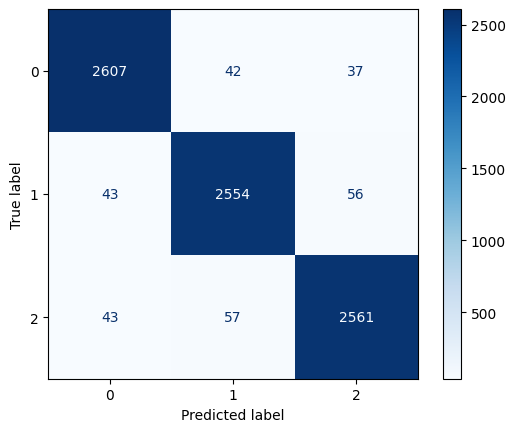

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion Matrix
cm = confusion_matrix(rf_y_test, rf_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_final_model.classes_)

# Display the confusion matrix
disp.plot(cmap="Blues", values_format="d")

**Approach 3: Using LGBM Classifier**

In [ ]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Step 1: Balance the Dataset (if necessary)
print("Class Distribution Before Balancing:")
print(pd.Series(y).value_counts())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class Distribution After Balancing:")
print(pd.Series(y_resampled).value_counts())

# Step 2: Feature Selection using Feature Importance
model_temp = LGBMClassifier(random_state=42)
model_temp.fit(X_resampled, y_resampled)

# Extract important features
feature_importances = model_temp.feature_importances_
important_features = [X.columns[i] for i in range(len(feature_importances)) if feature_importances[i] > 10]

# Filter the dataset
X_filtered = X_resampled[important_features]

# Step 3: Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2,],
    'subsample': [0.6, 0.8, 1],
    'min_child_samples': [10, 20, 30],
}


grid_search = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_filtered, y_resampled)

# Best Parameters
best_params = grid_search.best_params_
print("Best Parameters Found:", best_params)

# Step 4: Train with Tuned Parameters
final_model = LGBMClassifier(**best_params, random_state=42)
final_model.fit(X_filtered, y_resampled)

# Evaluate on Test Set
X_test_filtered = X_test[important_features]
y_pred = final_model.predict(X_test_filtered)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Improved Accuracy: {accuracy:.2f}")
print(f"Improved F1 Score: {f1:.2f}")
print(f"Improved Recall: {recall:.2f}")


Class Distribution Before Balancing:
0    13428
2    13307
1    13265
Name: count, dtype: int64
Class Distribution After Balancing:
2    13428
0    13428
1    13428
Name: count, dtype: int64
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 40284, number of used features: 18
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


# Generate metrics report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      2686
           1       0.87      0.88      0.88      2653
           2       0.88      0.88      0.88      2661

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000

Confusion Matrix:
 [[2353  173  160]
 [ 133 2347  173]
 [ 143  166 2352]]


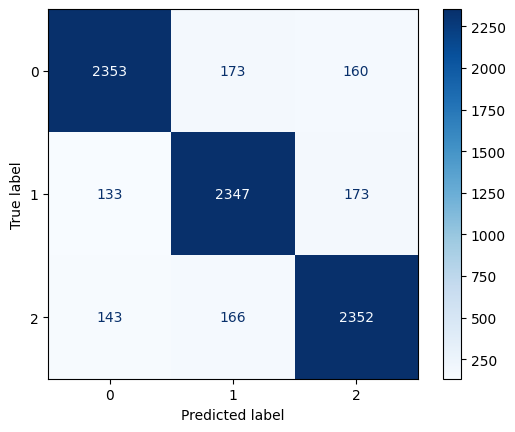

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)

# Display the confusion matrix
disp.plot(cmap="Blues", values_format="d")